In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings

In [6]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query(f'select * from {postgres_db}',con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [8]:
# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1),

# Standardize the data.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)


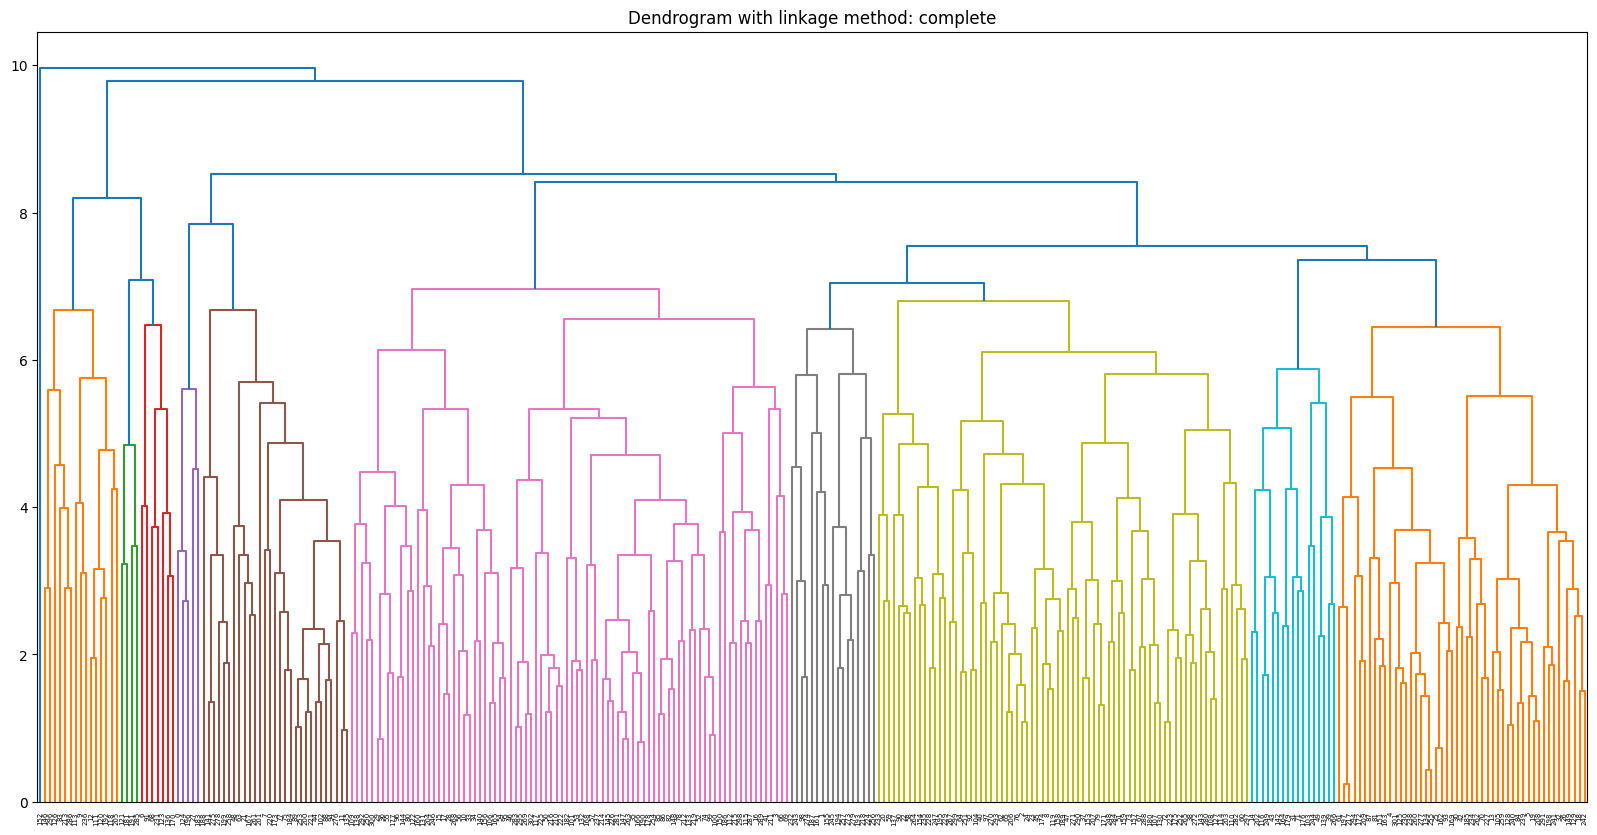

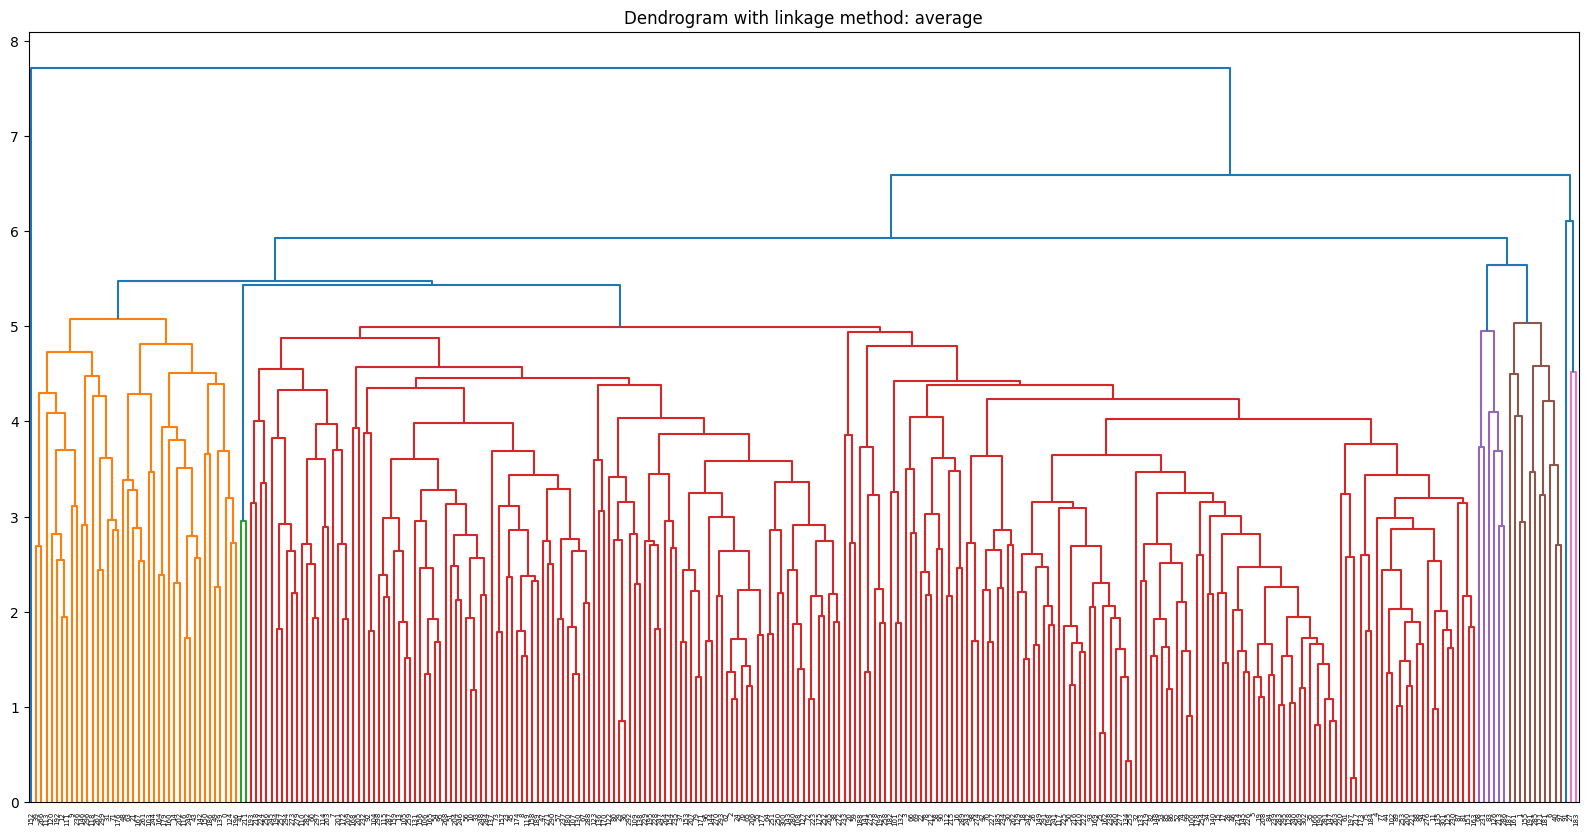

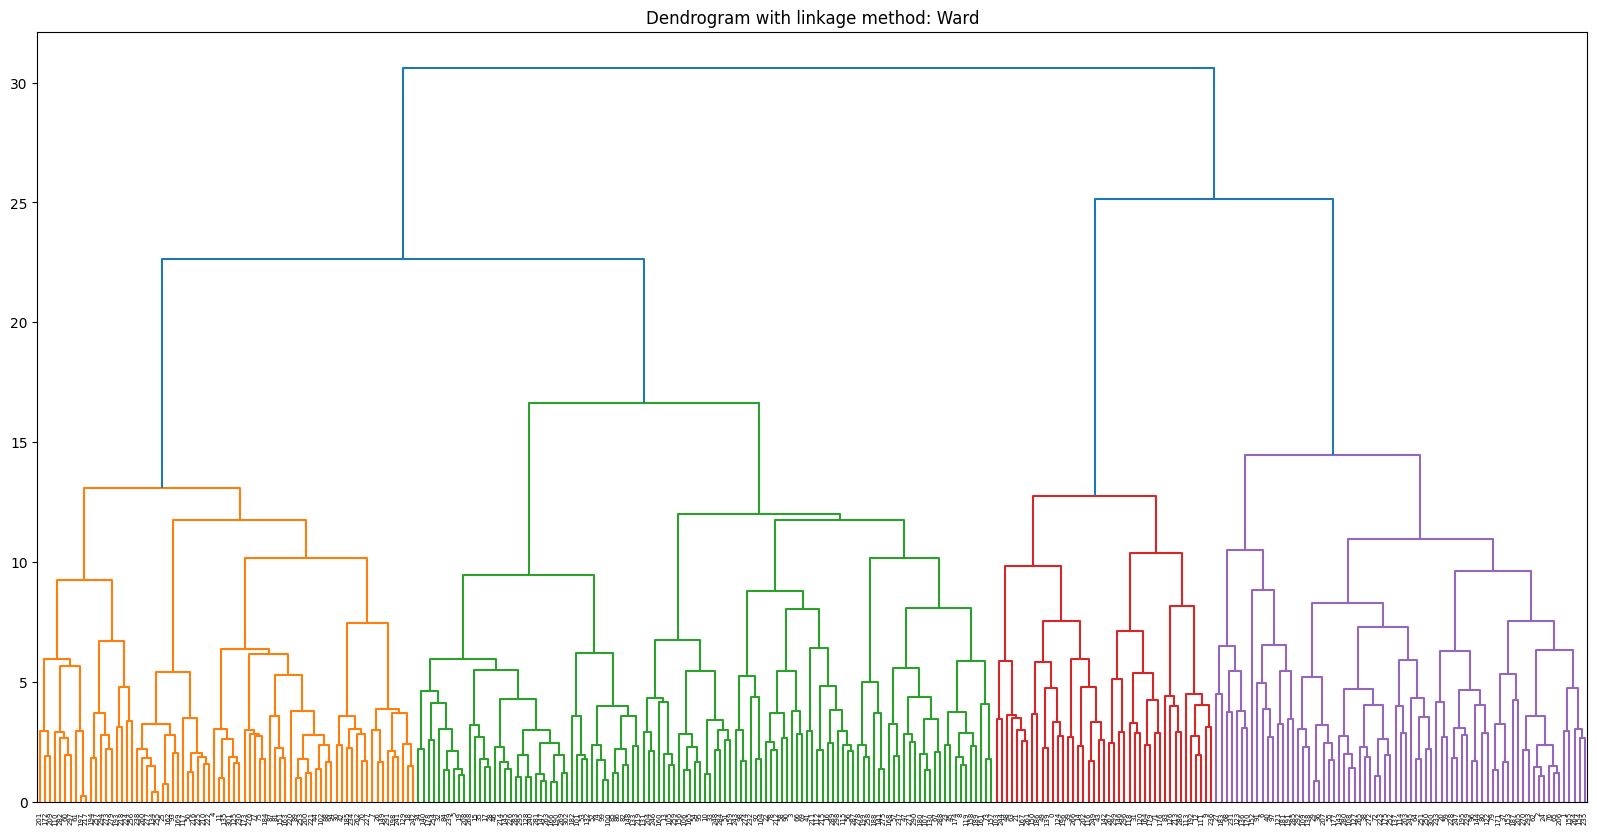

In [9]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

The best dendogram method is `ward`, as both `complete` and `average` produce results that are far more complex and difficult to reconcile.

In [19]:
# Create Agglomerative Clustering models with different linkage methods
ac_average = AgglomerativeClustering(n_clusters=2, linkage='average', metric='cosine')
ac_complete = AgglomerativeClustering(n_clusters=2, linkage='complete', metric='cosine')
ac_ward = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')

# Fit the models to the standardized data
y_ac_average = ac_average.fit_predict(X_std)
y_ac_complete = ac_complete.fit_predict(X_std)
y_ac_ward = ac_ward.fit_predict(X_std)


In [20]:
# Calculate ARI and silhouette score for each model
ari_average = adjusted_rand_score(y[0], y_ac_average)
silhouette_average = silhouette_score(X_std, y_ac_average)

ari_complete = adjusted_rand_score(y[0], y_ac_complete)
silhouette_complete = silhouette_score(X_std, y_ac_complete)

ari_ward = adjusted_rand_score(y[0], y_ac_ward)
silhouette_ward = silhouette_score(X_std, y_ac_ward)

# Print the scores for each model
print("Average linkage ARI:", ari_average)
print("Average linkage Silhouette Score:", silhouette_average)

print("Complete linkage ARI:", ari_complete)
print("Complete linkage Silhouette Score:", silhouette_complete)

print("Ward linkage ARI:", ari_ward)
print("Ward linkage Silhouette Score:", silhouette_ward)

# Identify the best method based on the scores
# Higher ARI and silhouette score are better
best_method = ""
if ari_average > ari_complete and ari_average > ari_ward and silhouette_average > silhouette_complete and silhouette_average > silhouette_ward:
    best_method = "Average"
elif ari_complete > ari_average and ari_complete > ari_ward and silhouette_complete > silhouette_average and silhouette_complete > silhouette_ward:
    best_method = "Complete"
else:
    best_method = "Ward"

print("The best method is:", best_method)


Average linkage ARI: 0.29404901333534655
Average linkage Silhouette Score: 0.14837359969689895
Complete linkage ARI: 0.21394030618551016
Complete linkage Silhouette Score: 0.11730765444448985
Ward linkage ARI: 0.146129913123814
Ward linkage Silhouette Score: 0.1387197366557222
The best method is: Average


In [22]:
# Create a KMeans model with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model to the standardized data
y_kmeans = kmeans.fit_predict(X_std)

# Calculate ARI and silhouette score for the KMeans model
ari_kmeans = adjusted_rand_score(y[0], y_kmeans)
silhouette_kmeans = silhouette_score(X_std, y_kmeans)

# Print the scores for the KMeans model
print("KMeans ARI:", ari_kmeans)
print("KMeans Silhouette Score:", silhouette_kmeans)


KMeans ARI: 0.42933471429719616
KMeans Silhouette Score: 0.17587312669470193


Comparing `Kmeans` to `Average Agglomerative Clustering`, `Kmeans` produces better scores. It aligns better both with ground truth, and has better defined clusters.